# P4J Periodogram demo

A simple demonstration of P4J's information theoretic periodogram

In [1]:
from __future__ import division
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import P4J

## Generating a simple synthetic light curve
We create an irregulary sampled time series using a harmonic model composed of three sine waves with an specified Signal to Noise Ratio SNR)

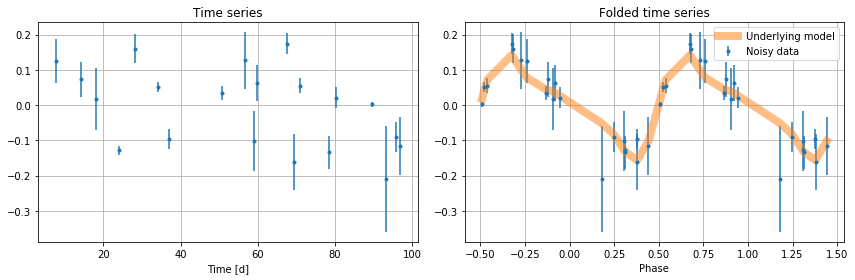

In [2]:
fundamental_freq = 2.0
lc_generator = P4J.synthetic_light_curve_generator(T=100.0, N=20)
lc_generator.set_model(f0=fundamental_freq, A=[1.0, 0.5, 0.25])

mjd, mag, err = lc_generator.draw_noisy_time_series(SNR=3.0, red_noise_ratio=0.25, outlier_ratio=0.0)
c_mjd, c_mag = lc_generator.get_clean_signal()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(mjd, mag, err, fmt='.')
ax.set_xlabel('Time [d]')
ax.set_title('Time series')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fundamental_freq)*fundamental_freq
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([mag[index], mag[index]]), 
            np.concatenate([err[index], err[index]]), fmt='.', alpha=1.0, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([c_mag[index], c_mag[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout()

## Finding the best frequency/period using P4J

Now let's assumme that we do not know the best frequency for this data. To find it, we sweep over a set of frequencies and find the one that maximizes the Quadratic Mutual Information (QMI) (or other criterion). 

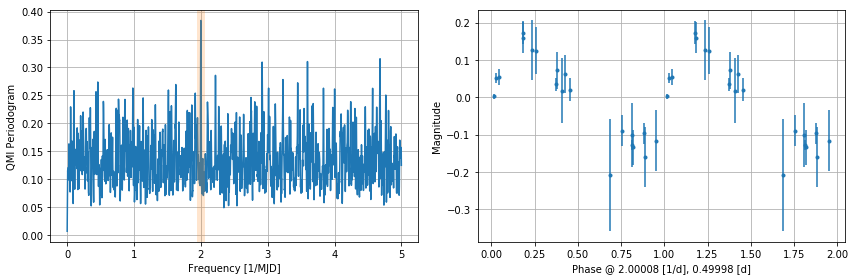

In [3]:
#my_per = P4J.periodogram(method='LKSL') # Phase Dispersion Minimization
#my_per = P4J.periodogram(method='PDM1')  # Lafler-Kinman's string length
my_per = P4J.periodogram(method='QMI')
my_per.set_data(mjd, mag, err)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=0.1)  # frequency sweep parameters
my_per.finetune_best_frequencies(fresolution=0.01, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('QMI Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([mag[idx], mag[idx]]),
            np.concatenate([err[idx], err[idx]]), fmt='.')

ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout()